In [1]:
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import special

# This will prompt for authorization. This enables to load files stored in your google drive
drive.mount('/content/drive')

Mounted at /content/drive


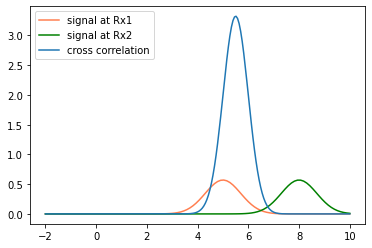

In [7]:
import scipy.stats
from scipy import signal
x_min = -2
x_max = 10
mean1 = 5
mean2 = 8
std = 0.7
x = np.linspace(x_min, x_max, 100)
y1 = scipy.stats.norm.pdf(x,mean1,std)
y2 = scipy.stats.norm.pdf(x,mean2,std)
x_plot =  np.linspace(x_min, x_max, 199)


corr = signal.correlate(y2, y1)

plt.figure()
plt.plot(x,y1, color='coral', label='signal at Rx1')
plt.plot(x,y2, color='green', label='signal at Rx2')
#plt.axvline(x=8,color='slateblue',linestyle='--')
plt.plot(x_plot,corr, label='cross correlation')
plt.legend() 
images_dir = '/content/drive/My Drive/Projet technologies spatiales'
plt.savefig(f'{images_dir}/cross correlation pos 3.jpeg',dpi = 500)
plt.show()

# Code suivant la méthode du mémoire de HAL


1.75e-05
[ 1598094.17142857   799518.47619048 12677241.9047619 ]
[ 5717485.71428571  2889142.85714286 46034285.71428572] [  3200.  32000. 320000.]
1.75e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


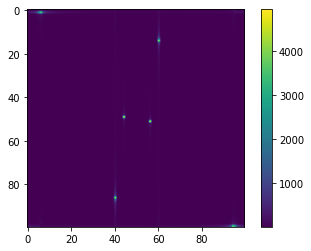

In [ ]:
# Variable du problème
fc  = 2.4e9
c = 3e8
Tramp = 17.5e-6 # larger of the ramp
Bsweep = 150e3 # bandwidth
print(Tramp)
# création des arrays avec les valeurs des 3 objets

v = np.array([200,2000,20000]) # 3 objets avec trois vitesse différentes
R0 = np.array([100e3,50e3,800e3]) # Les distances des trois objets

fD = fc*2*v/c # fréquence de Doppler
tau_0 = 2*R0/c # temps de l'aller retour
f_tau = (Bsweep/Tramp)*tau_0 
fb = Bsweep/Tramp * tau_0 + fD # frequence de battement
phi_0 = fc*tau_0 - (Bsweep*tau_0**2)/(2*Tramp) - fD*tau_0/2 # phase indépendante du temps
print(phi_0)
print(fb,fD)

# Amplitude du signal de retour
K_2prime = 1
Ae = 1

# Axe x
Nramp = 100
tl = np.linspace(0,(Nramp-1)*Tramp,Nramp)

# Axe y
n_sample = 100 # nombre d'échantillon par rampes
Ts = Tramp/n_sample # temps d'un échantillon
print(Ts)
tc = np.linspace(0,Tramp,n_sample) # array avec tous les échantillons d'une rampe

# Variable pour la création de la matrice
M = Nramp
N = n_sample
sB_sampled = np.zeros((N,M))

# Remplissage de la matrice selon la formule
for obj in range(3):
  for m in range(M): # boucle sur une rampe (une rampe est mise dans une colonne)
    for n in range(N): # boucle sur chaque rampe
      sB_sampled[n][m] += K_2prime * Ae * np.exp(1j*2*np.pi* (phi_0[obj] + fb[obj]*tc[n] + fD[obj]*tl[m]))


# FFT de la matrice crée
FFT = np.fft.fft2(sB_sampled)

# PLOT 
fig, ax = plt.subplots(1,1)
#x_min = -fD[-1]*c/(2*fc)
#x_max = fD[-1]*c/(2*fc)
#y_min = -(fb[-1] - fD[-1])*c*Tramp/(2*Bsweep)
#y_max = (fb[-1] - fD[-1])*c*Tramp/(2*Bsweep)
#rapport = round(y_max/x_max)
#y_min = y_min/rapport
#y_max = y_max/rapport
img = ax.imshow(abs(FFT),)#extent=[x_min,x_max,y_min,y_max])
fig.colorbar(img)
images_dir = '/content/drive/My Drive/Projet technologies spatiales'
#plt.savefig(f'{images_dir}/FFT2D.jpeg',dpi = 500)
#plt.xlabel("v [m/s]")
#plt.ylabel("R/40 [m]")


# Link budget

In [ ]:
import pandas as pd
import plotly.express as px

# Un cas exemple
k = 1.381e-23    # boltzman constant
B = 50e3 # Receiver bandwidth [Hz] -> à changer en fonction de la gamme de fréquence recues
T = 500 # Kelvin
f = 2.4e9  # frequency [Hz]
lamda = 3e8/f # wavelength [meter]
R = 400e3 # Earth-satellite mean distance [meter]
SNR = 10 # dB - signal to noise ratio
N = 10*np.log10(k * T * B) # dB - noise power
L = 2* 10*np.log10((4*np.pi*R/lamda)**2) # dB - free space losses
GR = 51 # dB antenna gain
EIRP = SNR + N + L - GR
print("The needed EIRP to have a SNR of",SNR,"dB at a distance of",R/1e3,"km is",round(EIRP,2),"dB")


def link_budget(Band,freq):
  # For all distance between 0 and 1000km
  R = np.arange(1,1000, step=1) # pour chaque km
  LEO = pd.DataFrame(index=R)
  N = 10*np.log10(k * T * Band)
  lamd = 3e8/freq
  for dist in R:
    LT = 0 # EDIT
    GT = 0 # EDIT
    L = 2*10*np.log10((4*np.pi*dist*10**3/lamd)**2) # 2 times because we need to go back and forth
    LEO.loc[dist,'EIRP (in dB)'] = SNR + N + L - GR
    LEO.loc[dist,'PT (in dB)'] = SNR + N + L - GR + LT - GT

  LEO['DISTANCE (in km)'] = LEO.index.to_series()
  fig = px.scatter(LEO, x='DISTANCE (in km)', y='EIRP (in dB)', log_x=True)
  fig.show()
  return LEO

# cas exemple
LEO1 =link_budget(50e3,2.4e9)
# diminution de la bande
LEO2 =link_budget(5e3,2.4e9)
# diminution de la fréquence
LEO3 = link_budget(50e3,2.4e6)  # ->la fréquence diminue beaucoup l'EIRP
# ====================== #

max_EIRP = LEO3['EIRP (in dB)'][999]
print(max_EIRP)
LT = 0
GT = 0
PT = EIRP + LT - GT
#EIRP_watt = 0.1 # maximum legal
# https://www.bakom.admin.ch/bakom/fr/page-daccueil/appareils-et-installations/equipements-particuliers/zulassige-sendeleistung-eirp.html
max_EIRP_watt = 10**(max_EIRP/10)
print(max_EIRP_watt)

The needed EIRP to have a SNR of 10 dB at a distance of 400.0 km is 108.56 dB


4.455950442107593
2.789941160855302


# Analyse de la résolution et distance maximale



In [ ]:
Fs = 1.5e6 # Hz
Tramp = 500e-6 # s
Bsweep = 125e3 # Hz
c = 3e8 # m/s
fc = 2.4e9 # Hz
slope = Bsweep/Tramp


# Distance maximale
dmax = (Fs*c)/(2*slope)
print("La distance maximale est de :",dmax/1000,"km")

# Espacement entre deux éléments
dresolution = c/(2*Bsweep)
print("La resolution en distance est de :",dresolution/1000,"km")

# Fréquence pour un objet à 450km
print(2*slope*450e3/c)



La distance maximale est de : 900.0 km
La resolution en distance est de : 1.2 km
750000.0


# Code pour obtenir certaines variables sur base des valeurs d'entrées

0.006666666666666667
320000.0
(100, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: ComplexWarning:

Casting complex values to real discards the imaginary part



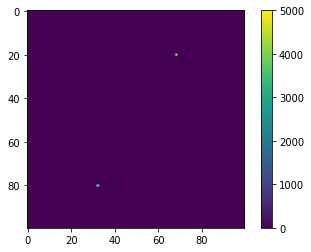

In [ ]:
# Inputs :
Tramp = 40e-6 # larger of the ramp
Bsweep = 100e6 # bandwidth
fc = 2.4e9 # carrier frequency (lowest value of the ramp) 
nbr_ramp = 10 # number of ramps = K-1
step = 100 # number of samples per ramp 
array_fT = [] # array contenant l'évolution de fT avec le temps
K = Bsweep/Tramp # raccourci
AT = 1 # amplitude transmitting signal
AR = 1 # amplitude receiving signal
R0 = 1000e3 # distance maximum de détection
c = 3e8 # speed of light
v = 20e3 # speed of object

# Variable for beat signal
tau_0 = 2*R0/c
print(tau_0)
tau_0 = 1e-2
fD = fc*2*v/c
print(fD)
f_tau = K*tau_0

# phi arrays 
phi_T = [] # array des déphasages de transmission
phi_B = [] # array des déphasages du beat signal

# Creation of the frequency fT :
for k in range(nbr_ramp):
  tk = np.linspace(k*Tramp,(k+1)*Tramp,step)
  fT = fc + K*(tk - k*Tramp)
  array_fT = np.append(array_fT,fT)

  sub_phi_T = 2*np.pi*(fc*tk + (K*tk**2)/2 -K*k*Tramp*tk)
  phi_T = np.append(phi_T,sub_phi_T)
  
  sub_phi_B = 2*np.pi*(fc*tau_0+ fD*k*Tramp + (f_tau+fD)*tk)
  phi_B = np.append(phi_B,sub_phi_B)

time_T = np.linspace(0,Tramp*nbr_ramp,nbr_ramp*step)

# Signal sent
sT = AT*np.cos(phi_T)
#plt.figure()
#plt.plot(time_T,sT)
#plt.show()


N = 100
K = 100
Ts = 1e-6
sB_sampled = np.zeros((K,N))
for k in range(K):
  for n in range(N):
    sB_sampled[k][n] = np.exp(1j*2*np.pi*(fc*tau_0 +fD*k*Tramp + (f_tau+fD)* n * Ts))


FFT = np.fft.fft2(sB_sampled)
print(FFT.shape)

plt.imshow(abs(FFT))
plt.colorbar()
#plt.xlim(0,20)
#plt.ylim(15,25)
plt.show() 


#plt.figure()
#plt.plot(time_T,array_fT)
#plt.show()













# RECEIVING PART
shift_f = 1
shift_t = 5e-6

# Creation of fR : 
array_fR = array_fT + shift_f
time_R = time_T + shift_t 





# Mixing both signals




# Cross correlation detection passive

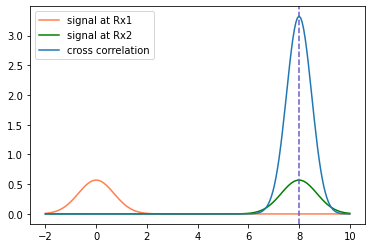

# Zone pour essai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ComplexWarning:

Casting complex values to real discards the imaginary part



4581.285642473248
(100, 100)


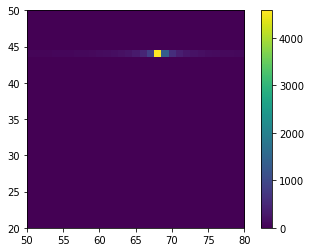

In [ ]:
# Pour chaque objet rencontré il y a une valeur pour les 3 variables suivantes.

# Simulation artificielle (normalement on a pas accès à ces données)
v = np.array([2000]) # 3 objets avec trois vitesse différentes
R0 = np.array([450e3]) # Les distances des trois objets

fc  = 2.4e9
c = 3e8
Tramp = 17.5e-6 # larger of the ramp
Bsweep = 150e6 # bandwidth

fD = fc*2*v/c
tau_0 = 2*R0/c
f_tau = (Bsweep/Tramp)*tau_0


N = 100
K = 100
Ts = 1e-6
sB_sampled = np.zeros((K,N))
for obj in range(1):
  for k in range(K):
    for n in range(N):
      sB_sampled[k][n] += np.exp(1j*2*np.pi*(fc*tau_0[obj] +fD[obj]*k*Tramp + (f_tau[obj]+fD[obj])* n * Ts))


FFT = np.fft.fft2(sB_sampled)
#FFT_shifted = np.fft.fftshift(FFT)
print(np.max(abs(FFT)))
print(FFT.shape)
plt.imshow(abs(FFT))
plt.xlim(50,80)
plt.ylim(20,50)
plt.colorbar()
images_dir = '/content/drive/My Drive/Projet technologies spatiales'
#plt.savefig(f'{images_dir}/Objet3_v20000_R800.jpeg',dpi = 500)

Je vais essayer d'adapter le code à ce que je devrai recevoir en théorie

21 20 1


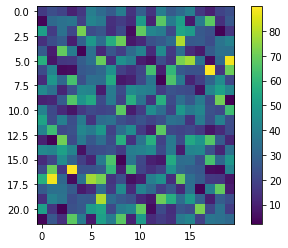

In [ ]:
# On reçoit un long array représentant sB[nTs] le signal de battement downsamplé à une fréquence de Ts

sB = np.zeros(421)
for i in range(len(sB)):
  sB[i] = np.random.uniform(-3,3)

# Cas ou on a pas d'office un nombre pratique. ex : 29 car il n'a pas deux diviseurs. On essaye de se rapprocher du carré parfait le plus proche
# un nombre = n^2 + reste
# on va créer une matrice de taille n+1 x n avec la dernière ligne zeropadée de (n-reste) 0.

from math import *
L = len(sB) # longueur de SB
cols = floor(np.sqrt(L))
rows = L//cols
# On peut faire "rows" lignes complètes
missing = L%cols
# Il manque "missing" chiffre pour compléter la dernière ligne
# On zero pad
print(rows,cols,missing)
sB = np.pad(sB, (0, cols-missing), 'constant')
sB = sB.reshape((rows+1,cols))

FFT = np.fft.fft2(sB)
plt.imshow(abs(FFT))
plt.colorbar()

# Determination des paramètres

In [ ]:
# Les paramètres ci-dessous sont déterminés par nos choix

Tramp = ... # Lorsque l'on génère le signal on choisit Tramp
Bsweep = ... # Lorsque l'on génère le signal on choisit Bsweep 
fc = ... # Lorsque l'on génère le signal on choisit fc 
Ts = ... # Dépend du downsampling




In [ ]:
"""
sB1 = ... # Signal received at antenna 1
sB2 = ... # Signal received at antenna 2

def sqr_norm(a):
  return np.norm(a)**2

maximal_amp = 0
deg_of_max = 0

# Iteration pour toute les directions possibles
for deg in range (0,180): # changer en fonction de l'ouverture de détection

  # Pas sur du tout
  phase = np.repeat(deg,len(sB1))
  phase3 = np.angle(sB1) + np.angle(sB2) + phase
  signal3 = np.exp(1j*(phase3))

  # Call square of the norm of the signal
  curr_norm = sqr_norm(signal3)

  if (curr_norm > maximal_amp):
    maximal_amp = curr_norm
    deg_of_max = deg

print("The direction of the object just detected is",deg_of_max,"degrees.")

"""

'\nsB1 = ... # Signal received at antenna 1\nsB2 = ... # Signal received at antenna 2\n\ndef sqr_norm(a):\n  return np.norm(a)**2\n\nmaximal_amp = 0\ndeg_of_max = 0\n\n# Iteration pour toute les directions possibles\nfor deg in range (0,180): # changer en fonction de l\'ouverture de détection\n\n  # Pas sur du tout\n  phase = np.repeat(deg,len(sB1))\n  phase3 = np.angle(sB1) + np.angle(sB2) + phase\n  signal3 = np.exp(1j*(phase3))\n\n  # Call square of the norm of the signal\n  curr_norm = sqr_norm(signal3)\n\n  if (curr_norm > maximal_amp):\n    maximal_amp = curr_norm\n    deg_of_max = deg\n\nprint("The direction of the object just detected is",deg_of_max,"degrees.")\n\n'

# Link budget

In [ ]:
R = 1000e3
fc = 2.4e9
lamda = 3e8/fc
L = (4*np.pi*R/lamda)**2
print(10*np.log(L))

368.519526932268
